# CS231n Winter 2016: Lecture 5
## Topics
- Neural Network
- Activation functions
- Data Preprocessing
- Weight Initialization
- Batch normalization
- Sanity check
- Process Visualization

## Sources
- video: https://www.youtube.com/watch?v=gYpoJMlgyXA
- original notes by Andrej Karpathy:
  - http://cs231n.github.io/neural-networks-2/

In [1]:
id = 'gYpoJMlgyXA'
from IPython.display import HTML
HTML(f'<iframe width="560" height="315" src="https://www.youtube.com/embed/{id}?rel=0&amp;controls=1&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

In [17]:
import math
import matplotlib.pyplot as plt
import numpy as np

## Sigmoid activation function
### Problems
- it kills gradient for big values (saturated neurouns "kills" the gradients)
- sigmoid outputs are not zero-centered
  - example: when the input for a neuron (x) is always positive all coeficiens of W will be all positive or negative
  $$
  f(\sum_i w_i x_i + b)
  $$
  and optimization will look like zig-zag path, slow convergence
  TODO: I don't really get why is it
- exp is bit compute exptensive

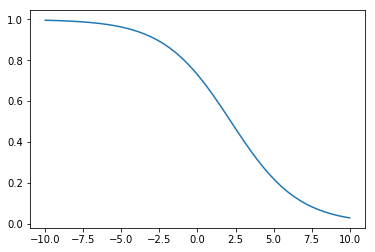

In [65]:
class Neuron:
    def __init__(self, inputs = 3):
        self.weights = np.random.randn(inputs,)
        self.bias = np.random.rand()

    def forward(self, inputs):
        """ assume inputs and weights are 1-D numpy arrays and bias is a number """
        value = inputs * self.weights
        if len(inputs.shape) > 1:
            value = np.sum(value, axis=-1)
        cell_body_sum = value + self.bias
        firing_rate = 1.0 / (1.0 + np.exp(-cell_body_sum)) # sigmoid activation function
        return firing_rate

data = np.linspace(-10, 10)
plt.plot(data, Neuron(1).forward(data))

## Relu
- Solves almost all problems of Sigmoid. Except
### Problems
- Not zero-centered output
- An annoyance - gradient of value less then 0 is 0.
  - dead Relu - it could comes on initial state - when W define that way that it only produce 0 gradient on input data
  - or it could become dead Relu after some iteration with high learning rate (step) optimization could set such high 
  values for W so it gets dead gradient and will never update. Andrej told that it possible to get 10% dead neurons 
  that way.
  - decrease changes - init bies = 0.01 (slightly positive numbers) - controversial point
  
## LeakyRelu
- Solve probem of `die relu`.

## PPeLU (Parameteric Rectifier)
$$
f(x) = max(\alpha x, x)
$$
and is learned $\alpha$ by backprop

## Exponential Linear Units (ELU)

## Maxout Neuron


## Preprocessing
- zero-centering
```
X -= np.mean(X, axis=0)
```
- normalize
```
X /= np.std(X, axis=0)
```
- decorrelat (PCA)
    ```python
    # get the data covariance matrix
    cov = np.dot(X.T, X) / X.shape[0]
    # the columns of `U` are the eigenvectors and `S` is a 1-D array of the singular values.
    U,S,V = np.linalg.svd(cov)
    # To decorrelate the data, we project the original (but zero-centered) data into the eigenbasis
    # Notice that the columns of `U` are a set of orthonormal vectors, so they can be regarded as basis vectors
    Xrot = np.dot(X, U) # decorrelate the data
    # covariance matrix of Xrot would be diagonal
    ```
  - [SVD](https://en.wikipedia.org/wiki/Positive-definite_matrix#Negative-definite.2C_semidefinite_and_indefinite_matrices)
  - reduce dimensionality `np.linalg.svd` returns U -- the eigenvector columns are sorted by their eigenvalues,
  - so we could get top few eigenvectors and discarding the rest:
  ```python
  Xrot_reduced = np.dot(X, U[:,:100])
  ```
  - this way we would keep data which have the most variance

- whitening - covariance matrix is identity matrix, normalize scale 
```python
# divide by the eigenvalues (which are square roots of the singular values)
Xwhite = Xrot / np.sqrt(S + 1e-5)
```
  - if the input data is a multivariable gaussian this tranformation makes them mean with zero and identity covariance matrix.
  - Warning: Exaggerating noise.

### For images commonly use zero-centering
- subtract the mean image [width, height, rgb]
- subtract per-channel mean [r,g,b]

## Weight initialization

### Shouldn't do
- $W = 0$
- small numbers
```
W = 0.001 * np.random.randn(D, H)
```
it works ok for small network but for big one you will get a problem: 
  - if we start with `mean = 0.0` and `std = 0.01` after each layer `mean` becomes more centered and `std -> 0`. and finally collapses to the `0`. Almost the same will be for gradient
- std = 1.0
```
W = 1.0 * np.random.randn(D, H)
```
  - if we start with `mean = 0.0` and `std = 1.0` after few layers `W` will be saturated to `-1` and `1`. Gradients also be all `0`
  
### Should do
- xavier initialization for `tanh`
```
W = np.random.randn(fan_in, fan_out) /np.sqrt(fan_in)
```
where `fan_in` - number of inputs
  - it still decrease standard deviation but not so dramatic as previous
  - it doesn't work for `ReLU` - decrese of standard deviation is much more rappid. Because `Relu` you 'kill' of distribution
  
- He et al. 2015
```
W = np.random.randn(fan_in, fan_out) /np.sqrt(fan_in / 2)
```
- biases set to zero 

## Batch normalization (Ioffe and Szegedy)
just make unit gaussian activation
$$
\hat{x}^{(k)} = \frac{x^{(k)} - E[x^{(k)}]}{\sqrt{Var[x^{(k)}]}}
$$
it works because it's completely (vanilla) differentiable function
- for each feature independently
- usage: `FC -> BN -> tanh -> FC -> BN -> tanh`. 
Because we are not sure that `tanh` would like gaussian on input. we shift and scale input:

$$
y^{(k)} = \gamma^{(k)} \hat{x}^{(k)} + \beta^{(k)}
$$.

and learn thoese params. But it could learn to disable batch norm by getting:

$$
\gamma^{(k)} = \sqrt{Var[x^{(k)}]}
$$
$$
\beta^{(k)} = E[x^{(k)}]
$$

### Features
- improves gradient flow through the network
- allow higher learning rates
- reduces the strong dependencies on initialization
- act as a form of regularization in a funny way, and slightly reduces the need for dropout, maybe

### Details
- in test time mean/std are fixed and could be estimated during training with running averages - because we want more deterministic function.

# Sanity check of nn
## check the loss function


- for 10 classes, with W init by `mean = 0` and `std = 0.0001` and `reg = 0.0` it should ~ log(10).
- with `reg = 1e3` it should going up

## try to overfit small pease data
- 20 examples, 10 labels
- turn off regularization `reg = 0`
- use vanilla `sgd`
- loss should be near `0`. and `100%` accuracy

## Hyper parameter optimization
- tune  learning rate
  - sometime cost decrease slowly but in contrast accuraccy step much quicker. The reason that accuracy just takes into account bigger score, but accuracy (in softmax) works with all scores, so they could be near each other but we already have right leaders
- coarse -> fine
- grid search -> random layout ([Random Search for Hyper-Parameter Optimization by Bergstra and Bengio](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf))
  - because usually one parameter is better than others so when we use grid search we just get much less data samples on the most significant parameter then if we randomize input a little bit
- implementation in cluster: `worker` run the model for random hyperparameters and store the result to files, name of file reflect performance, `master` launch/kill the `worker`-s
- usually developers prefer single validation set instead of cross-validation
- use log scale range for learning rate, but linear scale for drop-out
- start from wide range of parameters but less epoch (maybe 1) and then narrow range but increase epoches
- _Bayesian Hyperparameter Optimization_ - more sophisticated way to search optimal hyperparameters doesn't show significant results for ConvNets. [Discussion](http://nlpers.blogspot.com/2014/10/hyperparameter-search-bayesian.html)

### Evalution and Model Ensembles
- the best hyper parameters for the single model but with different initialization (problem - less variation)
- top few of hyperparameters (problem - could increase sub-optimal)
- different checkpoint of a single model (proc - very cheap, cos - less variation)
- _running average of parameters during training_
- [Geoff Hinton on “Dark Knowledge”](https://www.youtube.com/watch?v=EK61htlw8hY) - _"distill" a good ensemble back to a single model by incorporating the ensemble log likelihoods into a modified objective._ 
  
## Visualize process
- for example visulize all loss functions on cluster
  - https://lossfunctions.tumblr.com/ loss function could tell a lot
- accuracy
- different between parameters and scale of your update of those parameters 
  - it should be about 1e-3. (`dW * learning rate / W`)

# 